In [1]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

2.8.0
2.8.0


In [5]:
!pip install librosa
!pip install resampy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 47.2 MB/s  0:00:00


In [4]:
import math
import timeit
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import pandas as pd
import os, glob

import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from IPython.display import Audio

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# === (1) 데이터: 합성 스윕 대신 <<로컬 WAV>> 로드 ===
#     m4a는 torchaudio가 환경에 따라 못 읽으므로, 변환된 wav를 사용하세요.
WAV_PATH = "./audio_dataset/095522039.wav"   # 변환된 WAV 경로로 교체
assert os.path.exists(WAV_PATH), f"파일 없음: {WAV_PATH}"

waveform, sample_rate = torchaudio.load(WAV_PATH)   # [ch, time]
print(f"Loaded: {WAV_PATH} | shape={tuple(waveform.shape)} | sr={sample_rate}")

# === (2) 스펙트로그램 도식 함수: 스윕 전용이 아닌 일반 버전 ===
def plot_spectrogram_std(wf, sr, title):
    spec = T.Spectrogram(n_fft=1024, hop_length=256)(wf)
    spec_db = T.AmplitudeToDB()(spec).mean(dim=0)   # 채널 평균
    t_max = spec_db.shape[1] * 256 / sr
    f_max = sr / 2
    plt.figure(figsize=(10, 3))
    plt.imshow(spec_db.numpy(), origin="lower", aspect="auto",
               extent=[0, t_max, 0, f_max])
    plt.title(title); plt.xlabel("Time [s]"); plt.ylabel("Frequency [Hz]")
    plt.colorbar(label="dB"); plt.tight_layout(); plt.show()

Loaded: ./audio_dataset/095522039.wav | shape=(1, 177152) | sr=44100


/opt/anaconda3/envs/ai_lab/lib/python3.10/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


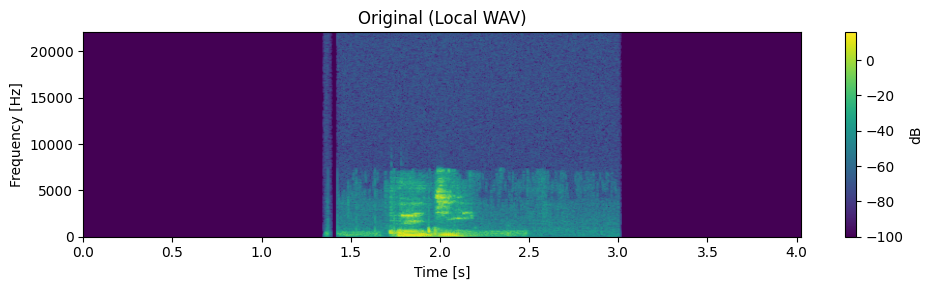

In [5]:
plot_spectrogram_std(waveform, sample_rate, "Original (Local WAV)")
Audio(waveform.numpy()[0], rate=sample_rate)

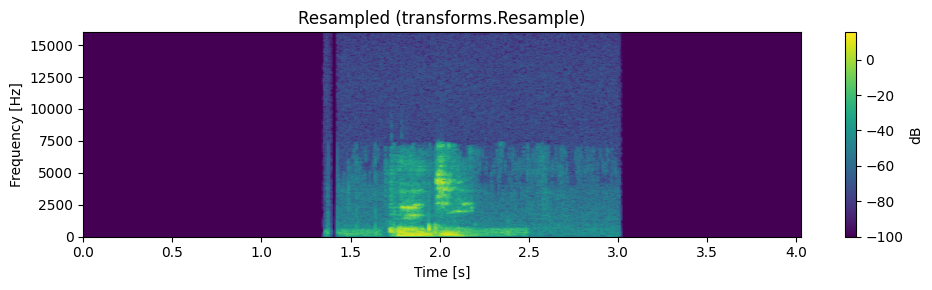

In [7]:
# Resample: transforms.Resample
resample_rate = 32000
resampler = T.Resample(sample_rate, resample_rate, dtype=waveform.dtype)
resampled_waveform = resampler(waveform)
plot_spectrogram_std(resampled_waveform, resample_rate, "Resampled (transforms.Resample)")
Audio(resampled_waveform.numpy()[0], rate=resample_rate)

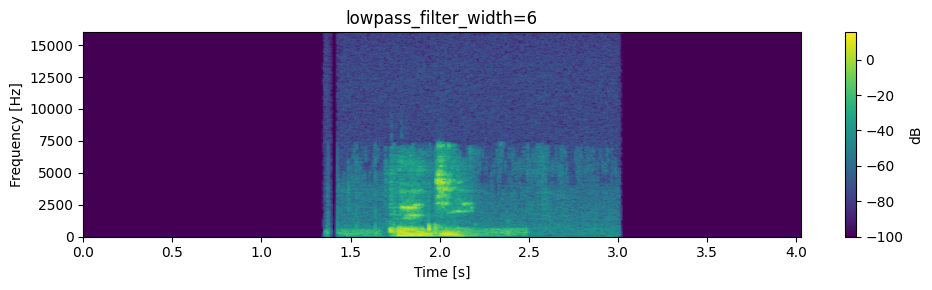

In [8]:
# 파라미터 효과: lowpass_filter_width 
resampled_waveform = F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=6)
plot_spectrogram_std(resampled_waveform, resample_rate, "lowpass_filter_width=6")


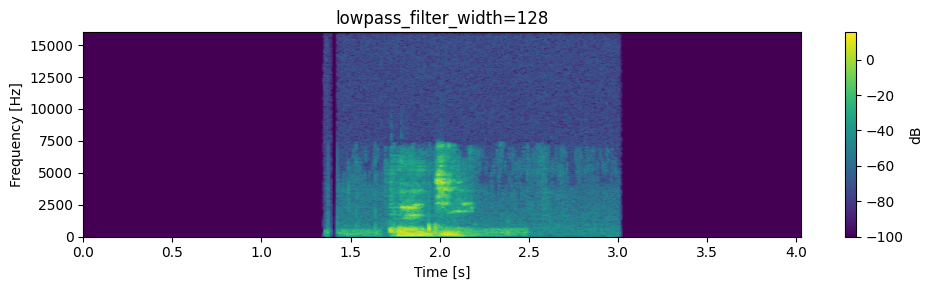

In [10]:
resampled_waveform = F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=128)
plot_spectrogram_std(resampled_waveform, resample_rate, "lowpass_filter_width=128") 

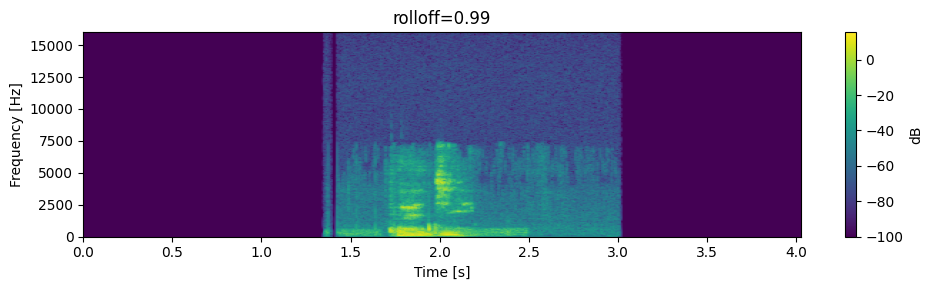

In [11]:
#파라미터 효과: rolloff 
resampled_waveform = F.resample(waveform, sample_rate, resample_rate, rolloff=0.99)
plot_spectrogram_std(resampled_waveform, resample_rate, "rolloff=0.99")

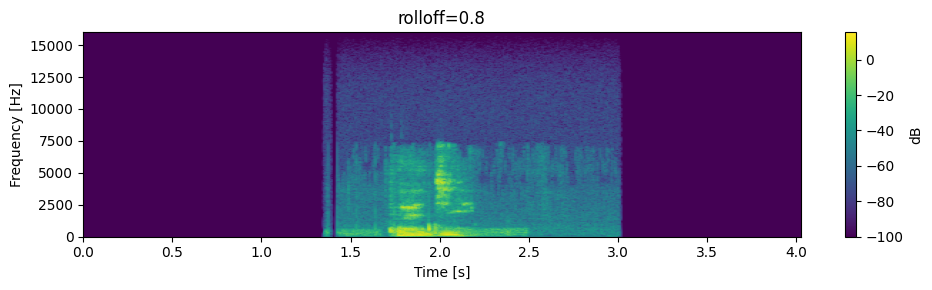

In [12]:
resampled_waveform = F.resample(waveform, sample_rate, resample_rate, rolloff=0.8)
plot_spectrogram_std(resampled_waveform, resample_rate, "rolloff=0.8")

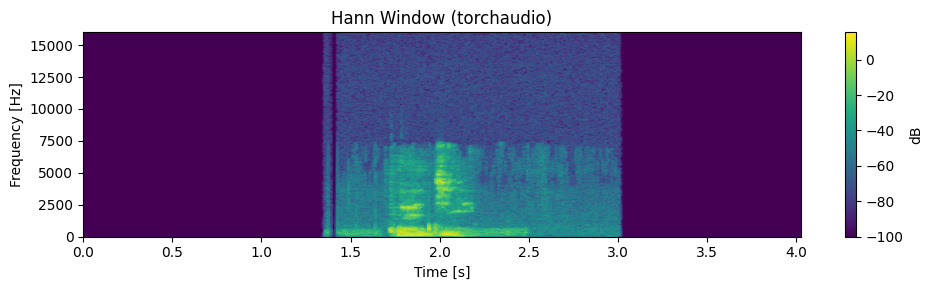

In [13]:
# Window 비교: Hann / Kaiser 
resampled_waveform = F.resample(waveform, sample_rate, resample_rate, resampling_method="sinc_interp_hann")
plot_spectrogram_std(resampled_waveform, resample_rate, "Hann Window (torchaudio)")

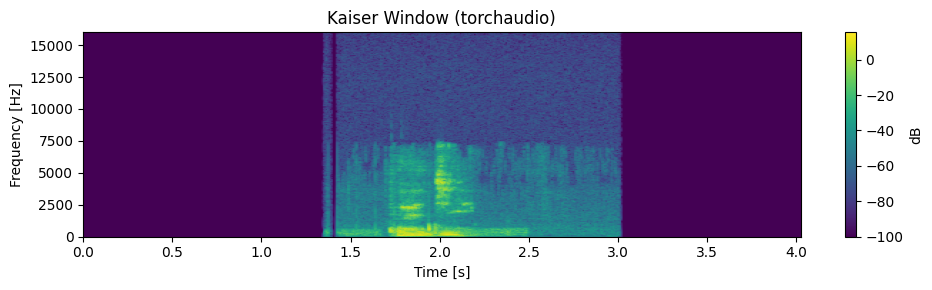

In [14]:
esampled_waveform = F.resample(waveform, sample_rate, resample_rate, resampling_method="sinc_interp_kaiser")
plot_spectrogram_std(resampled_waveform, resample_rate, "Kaiser Window (torchaudio)")

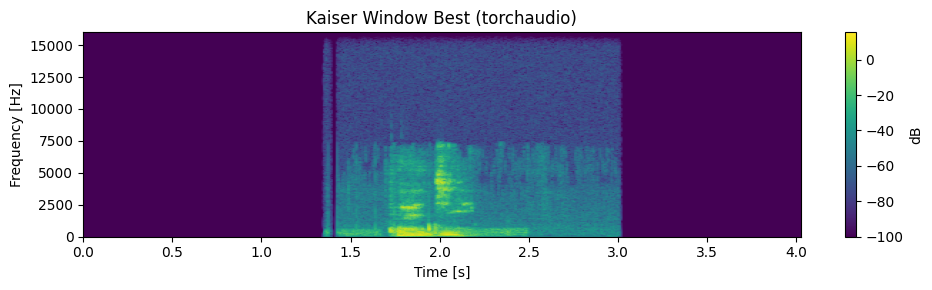

In [17]:
resampled_waveform = F.resample(
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=64,
    rolloff=0.9475937167399596,
    resampling_method="sinc_interp_kaiser",
    beta=14.769656459379492,
)
plot_spectrogram_std(resampled_waveform, resample_rate, "Kaiser Window Best (torchaudio)")

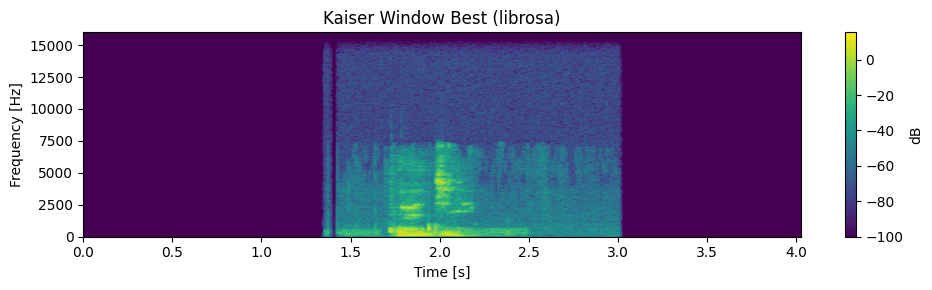

In [18]:
librosa_resampled_waveform = torch.from_numpy(
    librosa.resample(
        waveform.squeeze().numpy(),
        orig_sr=sample_rate,
        target_sr=resample_rate,
        res_type="kaiser_best"
    )
).unsqueeze(0)
plot_spectrogram_std(librosa_resampled_waveform, resample_rate, "Kaiser Window Best (librosa)")

In [19]:
mse = torch.square(resampled_waveform - librosa_resampled_waveform).mean().item()
print("torchaudio and librosa kaiser best MSE:", mse)

torchaudio and librosa kaiser best MSE: 9.399483144947873e-13


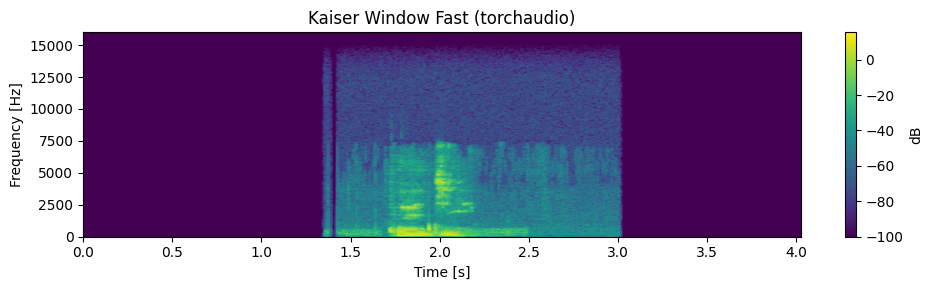

In [21]:
resampled_waveform = F.resample(
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=16,
    rolloff=0.85,
    resampling_method="sinc_interp_kaiser",
    beta=8.555504641634386,
)
plot_spectrogram_std(resampled_waveform, resample_rate, "Kaiser Window Fast (torchaudio)")

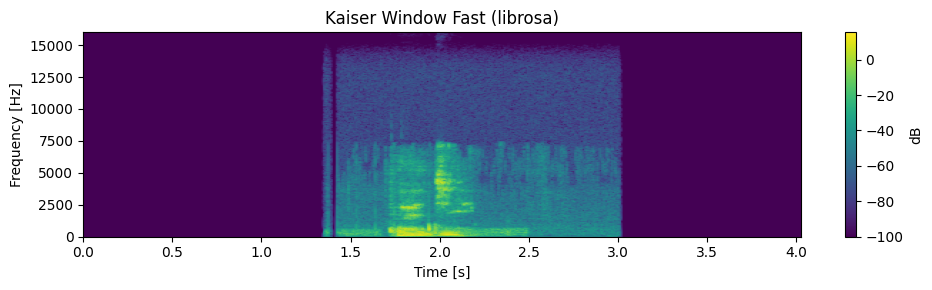

In [24]:
librosa_resampled_waveform = torch.from_numpy(
    librosa.resample(
        waveform.squeeze().numpy(),
        orig_sr=sample_rate,
        target_sr=resample_rate,
        res_type="kaiser_fast"
    )
).unsqueeze(0)
plot_spectrogram_std(librosa_resampled_waveform, resample_rate, "Kaiser Window Fast (librosa)")


In [25]:
mse = torch.square(resampled_waveform - librosa_resampled_waveform).mean().item()
print("torchaudio and librosa kaiser fast MSE:", mse)

torchaudio and librosa kaiser fast MSE: 9.744154268187533e-12


In [26]:
print(f"torchaudio: {torchaudio.__version__}")
print(f"librosa: {librosa.__version__}")
print(f"resampy: {resampy.__version__}")

torchaudio: 2.8.0
librosa: 0.11.0
resampy: 0.4.3


In [28]:
def benchmark_resample_functional(
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=6,
    rolloff=0.99,
    resampling_method="sinc_interp_hann",
    beta=None,
    iters=5,
):
    return (
        timeit.timeit(
            stmt="""
torchaudio.functional.resample(
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=lowpass_filter_width,
    rolloff=rolloff,
    resampling_method=resampling_method,
    beta=beta,
)
        """,
            setup="import torchaudio",
            number=iters,
            globals=locals(),
        )
        * 1000
        / iters
    )

In [29]:
def benchmark_resample_transforms(
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=6,
    rolloff=0.99,
    resampling_method="sinc_interp_hann",
    beta=None,
    iters=5,
):
    return (
        timeit.timeit(
            stmt="resampler(waveform)",
            setup="""
import torchaudio

resampler = torchaudio.transforms.Resample(
    sample_rate,
    resample_rate,
    lowpass_filter_width=lowpass_filter_width,
    rolloff=rolloff,
    resampling_method=resampling_method,
    dtype=waveform.dtype,
    beta=beta,
)
resampler.to(waveform.device)
        """,
            number=iters,
            globals=locals(),
        )
        * 1000
        / iters
    )

In [30]:
def benchmark_resample_librosa(
    waveform,
    sample_rate,
    resample_rate,
    res_type=None,
    iters=5,
):
    waveform_np = waveform.squeeze().numpy()
    return (
        timeit.timeit(
            stmt="""
librosa.resample(
    waveform_np,
    orig_sr=sample_rate,
    target_sr=resample_rate,
    res_type=res_type,
)
        """,
            setup="import librosa",
            number=iters,
            globals=locals(),
        )
        * 1000
        / iters
    )

In [31]:
def benchmark(sample_rate, resample_rate):
    times, rows = [], []
    waveform = get_sine_sweep(sample_rate).to(torch.float32)

    args = (waveform, sample_rate, resample_rate)

    # sinc 64 zero-crossings
    f_time = benchmark_resample_functional(*args, lowpass_filter_width=64)
    t_time = benchmark_resample_transforms(*args, lowpass_filter_width=64)
    times.append([None, f_time, t_time])
    rows.append("sinc (width 64)")

    # sinc 6 zero-crossings
    f_time = benchmark_resample_functional(*args, lowpass_filter_width=16)
    t_time = benchmark_resample_transforms(*args, lowpass_filter_width=16)
    times.append([None, f_time, t_time])
    rows.append("sinc (width 16)")

    # kaiser best
    kwargs = {
        "lowpass_filter_width": 64,
        "rolloff": 0.9475937167399596,
        "resampling_method": "sinc_interp_kaiser",
        "beta": 14.769656459379492,
    }
    lib_time = benchmark_resample_librosa(*args, res_type="kaiser_best")
    f_time = benchmark_resample_functional(*args, **kwargs)
    t_time = benchmark_resample_transforms(*args, **kwargs)
    times.append([lib_time, f_time, t_time])
    rows.append("kaiser_best")

    # kaiser fast
    kwargs = {
        "lowpass_filter_width": 16,
        "rolloff": 0.85,
        "resampling_method": "sinc_interp_kaiser",
        "beta": 8.555504641634386,
    }
    lib_time = benchmark_resample_librosa(*args, res_type="kaiser_fast")
    f_time = benchmark_resample_functional(*args, **kwargs)
    t_time = benchmark_resample_transforms(*args, **kwargs)
    times.append([lib_time, f_time, t_time])
    rows.append("kaiser_fast")

    df = pd.DataFrame(times, columns=["librosa", "functional", "transforms"], index=rows)
    return df

In [32]:
def plot(df):
    print(df.round(2))
    ax = df.plot(kind="bar")
    plt.ylabel("Time Elapsed [ms]")
    plt.xticks(rotation=0, fontsize=10)
    for cont, col, color in zip(ax.containers, df.columns, mcolors.TABLEAU_COLORS):
        label = ["N/A" if v != v else str(v) for v in df[col].round(2)]
        ax.bar_label(cont, labels=label, color=color, fontweight="bold", fontsize="x-small")

In [33]:
df = benchmark(48_000, 44_100)
plot(df)

NameError: name 'get_sine_sweep' is not defined

In [34]:
df = benchmark(16_000, 8_000)
plot(df)

NameError: name 'get_sine_sweep' is not defined

In [35]:
df = benchmark(44_100, 48_000)
plot(df)

NameError: name 'get_sine_sweep' is not defined

                 librosa  functional  transforms
sinc (width 64)      NaN        1.25        0.66
sinc (width 16)      NaN        0.51        0.26
kaiser_best         5.88        0.49        0.47
kaiser_fast         1.18        0.27        0.09


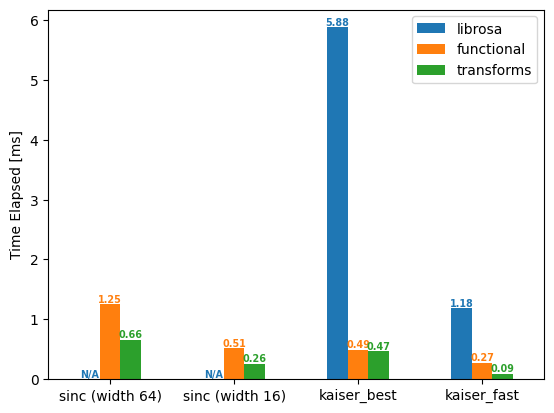

In [43]:
df = benchmark(8_000, 16_000)
plot(df)